# 07 - Audio
(Largely based on rbracco's tutorial, **big** thanks to him for his work on getting this going for us!)

`fastai2`'s audio module has been in development for a while by active forum members:

* [rbracco](https://github.com/rbracco)
* [kevinbird15](https://github.com/kevinbird15)
* [mogwai](https://github.com/mogwai)
* [Hiromis](https://github.com/hiromis)
* [scart97](https://github.com/scart97)
* [hoftherose](https://github.com/hoftherose)
* [madhavajay](https://github.com/madhavajay)
* [Jo](https://github.com/aquietlife/)

# What makes Audio different?

While it is possible to train on raw audio (we simply pass in a 1D tensor of the signal), what is done now is to convert the audio to what is called a **spectrogram** to train on.

![](https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png)

# Installing the `fastai2_audio` library:

We'll be installing from their `git` repository, similar to how we did for the dev version of `fastai2`

In [0]:
!pip install fastai2
!pip install git+https://github.com/rbracco/fastai2_audio.git

We'll also need `torchaudio`

# Free Digit Dataset

Essentially the audio version of `MNIST`, it contains 2,000 recordings from 4 speakers saying each digit 5 times. First, we'll grab the data and use a custom extract function:

In [0]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

`tar_extract_at_filename` simply extracts at the file name (as the name suggests)

In [0]:
def tar_extract_at_filename(fname, dest):
    "Extract `fname` to `dest`/`fname`.name folder using `tarfile`"
    dest = Path(dest)/Path(fname).with_suffix('').name
    tarfile.open(fname, 'r:gz').extractall(dest)

In [0]:
url = 'https://public-datasets.fra1.cdn.digitaloceanspaces.com/recordings.tar.gz'

In [0]:
path_dig = untar_data(url, extract_func=tar_extract_at_filename)/'recordings'

Now we want to grab just the audio files.

In [0]:
audio_extensions[:5]

('.aif', '.aifc', '.aiff', '.au', '.m3u')

In [0]:
fnames = get_files(path_dig, extensions=audio_extensions)

In [0]:
fnames[:5]

(#5) [Path('/root/.fastai/data/recordings.tar/recordings/9_yweweler_47.wav'),Path('/root/.fastai/data/recordings.tar/recordings/2_jackson_3.wav'),Path('/root/.fastai/data/recordings.tar/recordings/5_jackson_44.wav'),Path('/root/.fastai/data/recordings.tar/recordings/3_yweweler_48.wav'),Path('/root/.fastai/data/recordings.tar/recordings/8_nicolas_29.wav')]

We can convert any audio file to a tensor with `AudioTensor`. Let's try opening a file:

In [0]:
at = AudioTensor.create(fnames[0])

In [0]:
at, at.shape

(AudioTensor([[-6.1035e-05, -1.2207e-04, -6.1035e-05,  ..., -6.1035e-05,
           6.1035e-05, -9.1553e-05]]), torch.Size([1, 3451]))

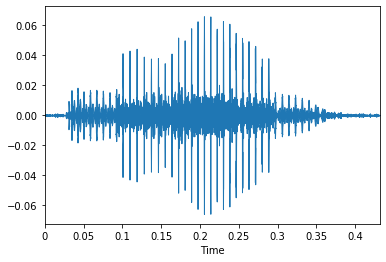

In [0]:
at.show()

# Preparing the dataset

`fastai2_audio` has a `AudioConfig` class which allows us to prepare different settings for our dataset. Currently it has:
* BasicMelSpectrogram
* BasicMFCC
* BasicSpectrogram
* Voice

We'll be using the **Voice** module today, as this dataset just contains human voices.

In [0]:
cfg = AudioConfig.Voice()

Our configuration will limit options like the frequency range and the sampling rate

In [0]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

We can then make a transform from this configuration to turn raw audio into a workable spectrogram per our settings:

In [0]:
aud2spec = AudioToSpec.from_cfg(cfg)

For our example, we'll crop out the original audio file to 1000 ms

In [0]:
crop1s = CropSignal(1000)

Let's build a `Pipeline` how we'd expect our data to come in

In [0]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

And try visualizing what our newly made data becomes:

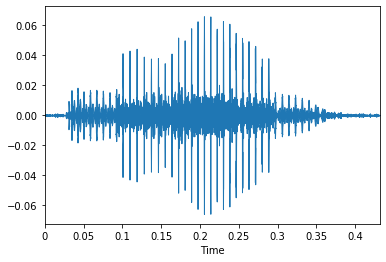

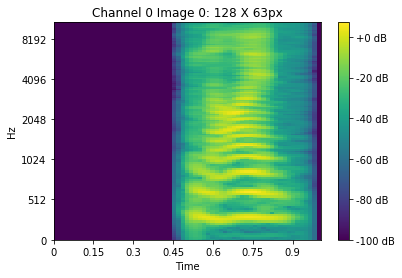

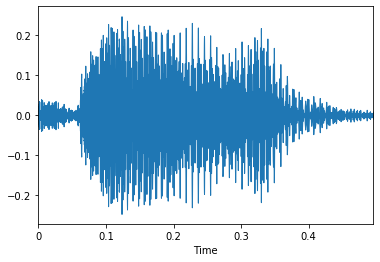

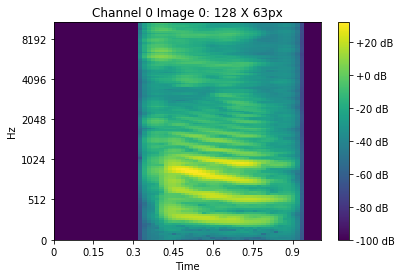

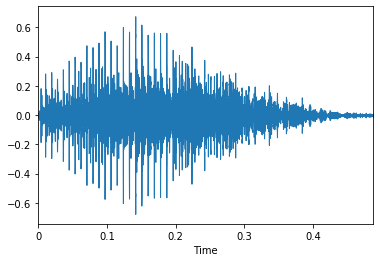

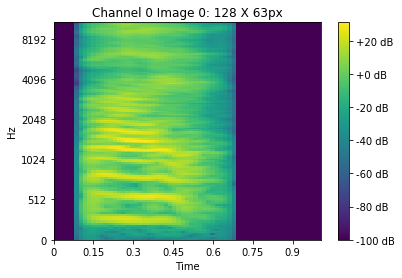

In [0]:
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

# Using the `DataBlock` API:

* We'll want to use our same transforms we used for the `Pipeline`
* An appropriate `getter`
* An appropriate labeller

For our transforms, we'll want the same ones we used before

In [0]:
item_tfms = [CropSignal(1000), aud2spec]

Our filenames are labelled by the number followed by the name of the individual:
* `4_theo_37.wav`
* `2_nicolas_7.wav`

In [0]:
get_y = lambda x: x.name[0]

In [0]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

And now we can build our `DataLoaders`

In [0]:
dls = aud_digit.dataloaders(path_dig, bs=64)

Let's look at a batch

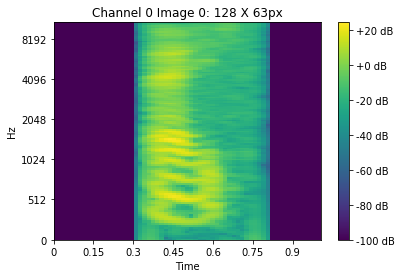

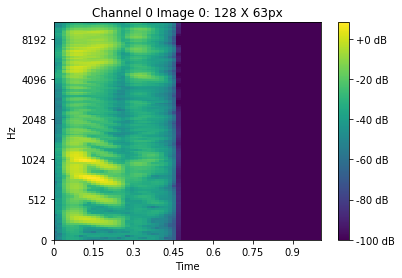

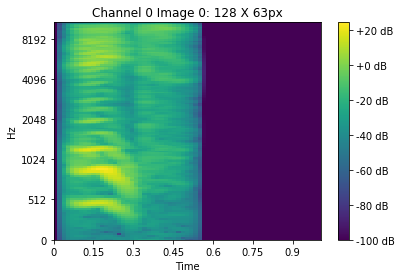

8
8
8


In [0]:
dls.show_batch(max_n=3)

# Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input (similar to how we did for the Bengali.AI model)

In [0]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [0]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

Now we need to grab our number of channels:

In [0]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [0]:
alter_learner(learn, n_c)

Now we can find our learning rate and fit!

(0.13182567358016967, 0.00363078061491251)

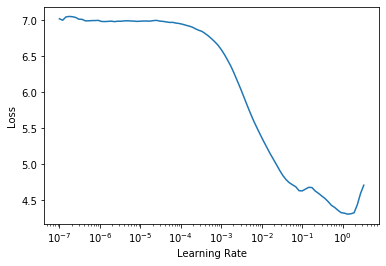

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.414628,21.140179,0.127500,00:06
1,2.353397,16.965506,0.112500,00:05
2,1.662053,1.892049,0.447500,00:05
3,1.092629,0.646519,0.792500,00:05
4,0.725536,0.292035,0.922500,00:05


In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.207173,0.275960,0.925000,00:06
1,0.186162,0.234892,0.940000,00:05
2,0.158674,0.198988,0.945000,00:05
3,0.132420,0.152389,0.957500,00:05
4,0.110699,0.147834,0.962500,00:05


Not bad for zero data augmentation! But let's see if augmentation can help us out here!

# Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us

In [0]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [0]:
aud2spec.settings

{'f_max': 8000.0,
 'f_min': 50.0,
 'hop_length': 128,
 'mel': 'True',
 'n_fft': 1024,
 'n_mels': 128,
 'nchannels': 1,
 'pad': 0,
 'sample_rate': 16000,
 'sr': 8000,
 'stype': 'power',
 'to_db': 'False',
 'top_db': None,
 'win_length': 1024,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None}

And we'll narrow this down a bit

In [0]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Now let's rebuild our `DataBlock`:

In [0]:
item_tfms = [RemoveSilence(), CropSignal(1000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [0]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

In [0]:
dls = aud_digit.dataloaders(path_dig, bs=128)

Let's look at some augmented data:

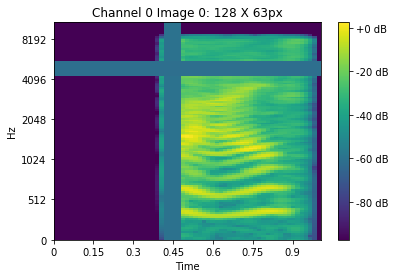

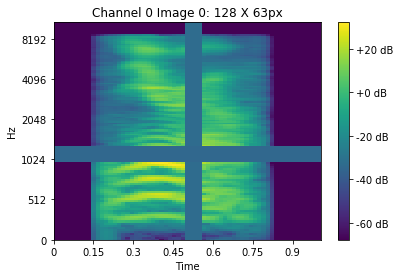

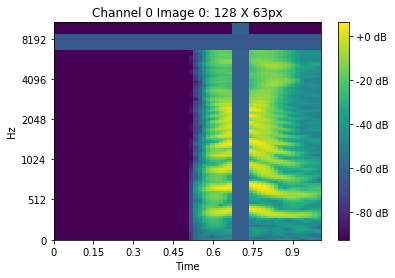

5
0
9


In [0]:
dls.show_batch(max_n=3)

Let's try training again. Also, since we have to keep making an adustment to our model, let's make an `audio_learner` function similar to `cnn_learner`:

In [0]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [0]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.012022644281387329, 0.00363078061491251)

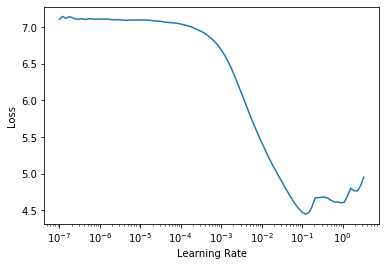

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.545658,5.734770,0.127500,00:08
1,4.609699,3.888712,0.120000,00:08
2,3.403854,5.129670,0.172500,00:08
3,2.679609,4.687058,0.265000,00:08
4,2.142527,1.905004,0.400000,00:08
5,1.720917,0.760010,0.757500,00:09
6,1.382670,0.500191,0.847500,00:08
7,1.108004,0.344360,0.902500,00:08
8,0.895391,0.281847,0.920000,00:08
9,0.733626,0.254196,0.920000,00:08


In [0]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.206378,0.236959,0.935000,00:08
1,0.200563,0.189735,0.945000,00:08
2,0.188825,0.217182,0.942500,00:08
3,0.177008,0.171911,0.957500,00:08
4,0.165546,0.184348,0.945000,00:08
5,0.156113,0.125590,0.975000,00:08
6,0.145428,0.137411,0.957500,00:08
7,0.138652,0.155575,0.940000,00:08
8,0.131871,0.130119,0.965000,00:08
9,0.128540,0.140389,0.965000,00:08


With the help of some of our data augmentation, we were able to perform a bit higher!

# Mel Frequency Cepstral Coefficient (MFCC)

Now let's look at that MFCC option we said earlier. MFCC's are a "linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency" - Wikipedia. But what does that mean?

![](https://www.researchgate.net/publication/335398843/figure/fig1/AS:796124961058818@1566822390492/MFCC-mel-frequency-cepstral-coefficients-characteristic-vectors-extraction-flow.png)

Let's try it out!

In [0]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,
                                             'n_mels':128})

In [0]:
item_tfms = [CropSignal(1000), aud2mfcc]

There's a shortcut for replacing the item transforms in a `DataBlock`:

In [0]:
aud_digit.item_tfms

(#6) [ToTensor: False (PILMask,object) -> encodes
(PILBase,object) -> encodes ,<function RemoveSilence.<locals>._inner at 0x7fc175e43c80>,<function CropSignal.<locals>._inner at 0x7fc175e43bf8>,AudioToSpec: False (AudioTensor,object) -> encodes ,<function MaskTime.<locals>._inner at 0x7fc175e43840>,<function MaskFreq.<locals>._inner at 0x7fc175e43d90>]

In [0]:
aud_digit.item_tfms = item_tfms

In [0]:
dls = aud_digit.dataloaders(path_dig, bs=128)

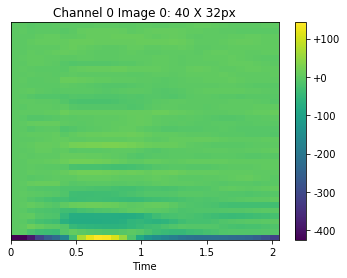

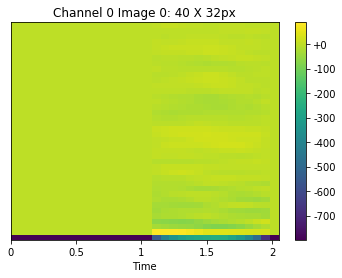

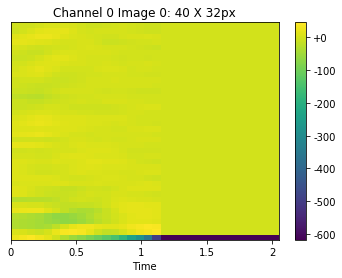

6
4
8


In [0]:
dls.show_batch(max_n=3)

Now let's build our learner and train again!

In [0]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.012022644281387329, 0.00363078061491251)

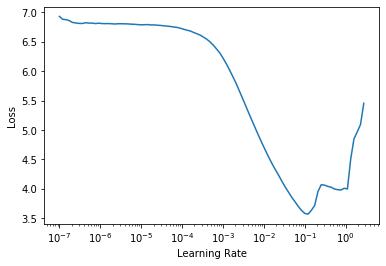

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.433520,3.334920,0.125000,00:05
1,1.778672,2.342561,0.442500,00:05
2,1.105908,0.731669,0.730000,00:05
3,0.751198,0.303158,0.887500,00:05
4,0.534151,0.089569,0.977500,00:05


Now we can begin to see why choosing your augmentation is important!

# MFCC + Delta:

The last transform we'll discuss is the `Delta` transform:

> Local estimate of the derivative of the input data along the selected axis.

This allows multiple-channeled inputs from one signal

In [0]:
item_tfms = [CropSignal(1000), aud2mfcc, Delta()]

In [0]:
aud_digit.item_tfms = item_tfms

In [0]:
dls = aud_digit.dataloaders(path_dig, bs=128)

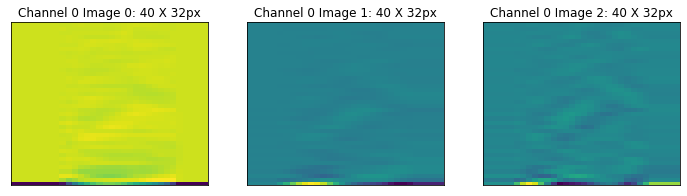

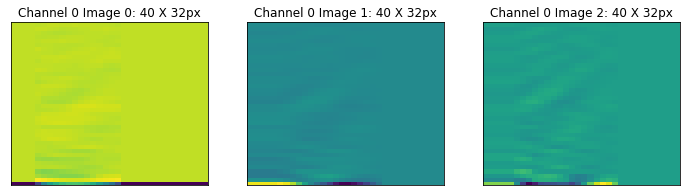

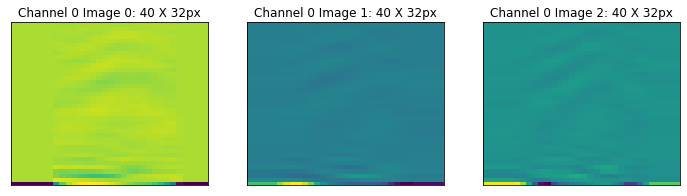

7
1
5


In [0]:
dls.show_batch(max_n=3)

Let's try training one more time:

In [0]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.04365158379077912, 0.0030199517495930195)

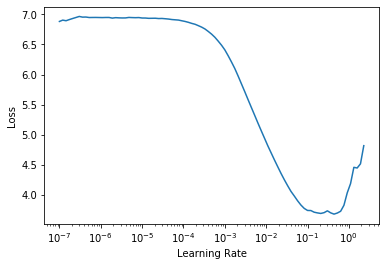

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.603416,2.720085,0.230000,00:08
1,1.835890,2.379193,0.562500,00:08
2,1.136467,1.529768,0.575000,00:08
3,0.772449,0.561064,0.827500,00:08
4,0.549078,0.108505,0.975000,00:08


Let's try fitting for a few more:

In [0]:
learn.fit_one_cycle(5, 1e-2/10)

epoch,train_loss,valid_loss,accuracy,time
0,0.042916,0.089183,0.982500,00:08
1,0.038856,0.078018,0.982500,00:08
2,0.034573,0.066879,0.980000,00:08
3,0.029855,0.075289,0.982500,00:08
4,0.027841,0.072155,0.980000,00:08
